In [1]:
import os

#import matplotlib
#matplotlib.use('MACOSX')
#for some reason if I run these 2 lines - it doesnt plot at all any more.


import numpy as np
import mne
import matplotlib.pyplot as plt
from copy import deepcopy
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


In [2]:
def load_meg_data(raw_file=None):
    #Load data AND SEPARATE MAGS AND GRADS. How do we want to input the path file here?

    #raw_file = os.path.join('Katharinas_Data','sub_HT05ND16', '210811', 'mikado-1.fif')                               
    raw = mne.io.read_raw_fif(raw_file)

    #Separate mags and grads:
    mags = [(chs['ch_name'], i) for i, chs in enumerate(raw.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
    grads = [(chs['ch_name'], i) for i, chs in enumerate(raw.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]

    return(raw, mags, grads)


In [3]:
# run load:
#raw_file = os.path.join('Katharinas_Data','sub_HT05ND16', '210811', 'mikado-1.fif')  
raw_file = './data/sub_HT05ND16/210811/mikado-1.fif/'
raw, mags, grads=load_meg_data(raw_file=raw_file)

Opening raw data file ./data/sub_HT05ND16/210811/mikado-1.fif/...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 3

/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_37269/3339949254.py:5: RuntimeWarning: This filename (./data/sub_HT05ND16/210811/mikado-1.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file)


In [4]:
def make_folders_meg(sid='1'):
#Create folders (if they dont exist yet)

#sid is subject Id, must be a string.
#Folders are created in BIDS-compliant directory order: 
#Working directory - Subject - derivtaives - megQC - csvs and figures

    #This is the list of folders and subfolders to be created. Loop checks if directory already exists, if not - create.
    #Make sure to add subfolders on the list here AFTER the parent folder.

    #DO WE NEED TO CREATE IT ACTUALLY NOT IN CURRENT DIRECTORY, BUT GO ONE STEP UP FROM CURRENT DIRECTORY AND THEN CREAT DERIVATIVES?

    path_list = [f'./derivatives', 
    f'./derivatives/sub-{sid}',
    f'./derivatives/sub-{sid}/megqc',
    f'./derivatives/sub-{sid}/megqc/csv files',
    f'./derivatives/sub-{sid}/megqc/figures']

    print(path_list)

    for path in path_list:
        if os.path.isdir(path)==False: #if directory doesnt exist yet - create
            os.mkdir(path)

In [5]:
make_folders_meg(sid='1')

['./derivatives', './derivatives/sub-1', './derivatives/sub-1/megqc', './derivatives/sub-1/megqc/csv files', './derivatives/sub-1/megqc/figures']


In [6]:
#crop the data to calculate faster

raw_cropped = raw.copy()
raw_cropped.crop(0, 300) #(first 5 min)

<Raw | mikado-1.fif, 319 x 300001 (300.0 s), ~6.6 MB, data not loaded>

In [7]:
#Filter the data and downsampling. see comments!

def filter_and_resample_data(data=None,l_freq=None, h_freq=None, method='iir'):
    # Filtering the data. Recommended: 1-100Hz bandpass or 0.5-100 Hz - better for frequency spectrum
    # https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.filter

    # method='iir' - I m using here the Butterworth filter similar to filtfilt in matlab, like we  
    # did in the course with eeg data. such filter creates no time shift, since it filters forward and backward.
    # But we might use a different filter as well. I dont know if this one is the best possible option.

    #Data has to be loaded into mememory before filetering:
    data.load_data(verbose=True)
    raw_bandpass = data.copy()
    raw_bandpass.filter(l_freq=l_freq, h_freq=h_freq, picks='meg', method=method, iir_params=None)

    #And resample:
    #LOOK AT THE WARNING HERE https://mne.tools/stable/generated/mne.io.Raw.html?highlight=resample#mne.io.Raw.resample
    #It s not recommended to epoch resampled data as it can mess up the triggers.
    #We can either downsample after epoching - if needed. https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.resample
    #And here downsample the continuous data - and use it further only in continuouys form, no epoching. This is why 2 options returned.

    raw_bandpass_resamp=raw_bandpass.copy()
    raw_bandpass_resamp.resample(sfreq=h_freq*5)
    #frequency to resample is 5 times higher than the maximum chosen frequency of the function

    return(raw_bandpass, raw_bandpass_resamp)

    #JOCHEM SAID: Try turning off the aliasing filter in downsampling. Not sure how?


In [8]:
#apply filtering

filtered_d, filtered_d_resamp=filter_and_resample_data(data=raw_cropped,l_freq=0.5, h_freq=100, method='iir')

Reading 0 ... 300000  =      0.000 ...   300.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB

Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
301 events found
Event IDs: [    9    19    21    23    27    31 16393 16402 16403 16405 16411 32741
 32746 32749 32750 32759]


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_37269/1734743608.py:23: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)


Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
253 events found
Event IDs: [    9    19    20    21    22    23    27    31 16393 16402 16403 16405
 16411 32741 32746 32749 32750 32759]


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_37269/1734743608.py:23: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)


In [9]:
def Epoch_meg(data=None, stim_channel='STI101', event_dur=1.2, epoch_tmin=-0.2, epoch_tmax=1):
#Gives epoched data i2 separatet data frames: mags and grads


       picks_grad = mne.pick_types(data.info, meg='grad', eeg=False, eog=False, stim=False)
       picks_magn = mne.pick_types(data.info, meg='mag', eeg=False, eog=False, stim=False)

       events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)
       n_events=len(events)

       epochs_mags = mne.Epochs(data, events, picks=picks_magn, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None)
       epochs_grads = mne.Epochs(data, events, picks=picks_grad, tmin=epoch_tmin, tmax=epoch_tmax, preload=True, baseline = None)

       #Present epochs as data frame - separately for mags and grads
       df_epochs_mags = epochs_mags.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))
       df_epochs_grads = epochs_grads.to_data_frame(time_format=None, scalings=dict(mag=1, grad=1))

       return(n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads)
       #Returns: 
       # number of events(=number of epochs), 
       # data frame containing data for all epochs: mags and grads separately
       # epochs as mne data structure (not used anywhere, we may use it for something in the future)





In [10]:
#Apply epoching: USE NON RESAMPLED DATA. Or should we resample after epoching? Since sampling freq is 1kHz and resampling is 500Hz, it s not that much of a win...

n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads=Epoch_meg(data=filtered_d, stim_channel='STI101', event_dur=1.2, epoch_tmin=-0.2, epoch_tmax=1)


Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
8 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
8 matching events found


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_37269/2534005067.py:8: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)


No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped


In [11]:
#%% RMSE - general function to use in other functions
#STD CALCULATION IS MUCH LESS COdE BUT TAKES LONGER THAN RMSE

def RMSE(data_mags=None, data_grads=None):

    # https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python

    from sklearn.metrics import mean_squared_error

    #Magnitometers:
    y_actual_mags=data_mags #refrence to data_mags
    y_predicted_mags=data_mags.mean(axis=1)

    rmse_mags = np.zeros(len(y_predicted_mags)) #RMSE of all magnetometers

    for i in range(len(y_predicted_mags)):
        y_predicted_vec_mags=np.ones(len(y_actual_mags[0]))*y_predicted_mags[i]
        rmse_mags[i] = mean_squared_error(y_actual_mags[i, :], y_predicted_vec_mags, squared=False)


    #Gradiometers:
    y_actual_grads=data_grads #refrence to data_grads
    y_predicted_grads=data_grads.mean(axis=1)

    rmse_grads = np.zeros(len(y_predicted_grads)) #RMSE of all gradiometers

    for i in range(len(y_predicted_grads)):
        y_predicted_vec_grads=np.ones(len(y_actual_grads[0]))*y_predicted_grads[i]
        rmse_grads[i] = mean_squared_error(y_actual_grads[i, :], y_predicted_vec_grads, squared=False)

    return(rmse_mags, rmse_grads)


In [12]:
# Root mean squared error calculation (or STD - same result) over all data:

def RMSE_meg_all(data=None, mags=mags, grads=grads, std_lvl=1, plotflag=True, sid='1'): #, min_duration_event=1, epoch_tmin=-0.2, epoch_tmax=1):
    #give path to directory and then it should auto find the data file when bids compliant.
    ##maybe distinguish between negative and positive std_lvl

    #plotflag - plot or no plot
    #sid - subject Id. Has to be a string , like '1'
    #mags, grads - channels like [name, index]
  

    # Separate data for mags and grads in 2 arrays.
    selected_mags = [item[1] for item in mags]
    selected_grads = [item[1] for item in grads]
    data_mags, times = data[selected_mags, :]  
    data_grads, times = data[selected_grads, :]  

    # %% Calculate STD or RMSE of each channel

    #Calculate RMSE for each channel (separated mags and grads) - for the entire time duration:
    std_mags, std_grads = RMSE(data_mags=data_mags, data_grads=data_grads)

    #STD (if wanna use insted of RMSE. it will exactly replace the RMSE function above):
    #std_mags=np.std(data_mags, axis=1) #calculate std of all magnetometers (along second dimantion)
    #std_grads=np.std(data_grads, axis=1) #calculate std of all gradiometers (along second dimantion)


    # Check if channel data is within 1 std over all channels.
    # COMMENT: can use -3 to 3 (or other number) std istead of -1/+1 std, but this can adjusted later. 
    # 1 std is too narrow, gives way too many bad channels.

    std_std_mags=np.std(std_mags)
    std_std_grads=np.std(std_grads)

    mean_std_mags=np.mean(std_mags)
    mean_std_grads=np.mean(std_grads)

    ch_ind_large_std_mags= np.where(std_mags > mean_std_mags+std_lvl*std_std_mags) #find magn channels with largest std
    ch_ind_large_std_grads= np.where(std_grads > mean_std_grads+std_lvl*std_std_grads) 
    ch_ind_small_std_mags= np.where(std_mags < mean_std_mags-std_lvl*std_std_mags) #find magn channels with smallest std
    ch_ind_small_std_grads= np.where(std_grads < mean_std_grads-std_lvl*std_std_grads)

    magn_channel_big_std=np.array(mags)[ch_ind_large_std_mags] #find the name of the magn with largest std 
    grad_channel_big_std=np.array(grads)[ch_ind_large_std_grads]
    magn_channel_small_std=np.array(mags)[ch_ind_small_std_mags]
    grad_channel_small_std=np.array(grads)[ch_ind_small_std_grads]


    #This function simply makes a list of tuples. Each tuple is: name of channel, std value.
    #Each tuple represents channel with too big or too small std, calculated over whole data.

    def Channels_with_nonnormal_stds(ch_ind, all_stds_m_or_g, channels_big_std_names):
        channel_big_std_vals=all_stds_m_or_g[ch_ind]
        nonnormal_std_with_value=[]
        for id, val in enumerate (ch_ind[0]):
            new_tuple=(channels_big_std_names[id][0],  channel_big_std_vals[id])
            nonnormal_std_with_value.append(new_tuple)
        return(nonnormal_std_with_value)

    #Apply function above:
    m_big_std_with_value=Channels_with_nonnormal_stds(ch_ind_large_std_mags, std_mags, magn_channel_big_std)
    g_big_std_with_value=Channels_with_nonnormal_stds(ch_ind_large_std_grads, std_grads, grad_channel_big_std)
    m_small_std_with_value=Channels_with_nonnormal_stds(ch_ind_small_std_mags, std_mags, magn_channel_small_std)
    g_small_std_with_value=Channels_with_nonnormal_stds(ch_ind_small_std_grads, std_grads, grad_channel_small_std)


    #OLd STD figure:
    if plotflag==True:
        
        from matplotlib import pyplot as plt

        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle('STDs')
        ax1.plot(list(range(1, len(std_mags)+1)), std_mags, marker='o', linestyle = 'None')
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags]*len(std_mags))
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags-std_lvl*std_std_mags]*len(std_mags))
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags+std_lvl*std_std_mags]*len(std_mags))
        ax1.set(xlabel='Magnetometer', ylabel='STD')

        ax2.plot(list(range(1, len(std_grads)+1)), std_grads, marker='o', linestyle = 'None')
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads]*len(std_grads))
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads-std_lvl*std_std_grads]*len(std_grads))
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads+std_lvl*std_std_grads]*len(std_grads))
        ax2.set(xlabel='Gradiometer', ylabel='STD')

        plt.savefig('./derivatives/sub-'+sid+'/megqc/figures/RMSE_all_channels.png')

        
    #Return the channel names with STD over the set STD level and under the set negative STD level.
    return(m_big_std_with_value, g_big_std_with_value, m_small_std_with_value, g_small_std_with_value, std_mags, std_grads)


    #CAN ADD OPTIONAL PLOTTING OF SOME CHANNELS WITH HIGH/LOW STD. DO WE NEED THAT?
    #WHAT DO WE WANT TO GIVE AS OUTPUT HERE? NEED PLOTS, NEED LIST OF CHANNELS?

Magnetometers with high std:


[('MEG0621', 4.965338372879145e-13),
 ('MEG1021', 4.852992071039414e-13),
 ('MEG1031', 5.004345361972638e-13),
 ('MEG1041', 4.939759752048587e-13),
 ('MEG1421', 5.678604995893133e-13),
 ('MEG1431', 5.476084157649638e-13),
 ('MEG1741', 5.282172136198286e-13),
 ('MEG2121', 5.018134686600477e-13),
 ('MEG2131', 5.860882537731944e-13),
 ('MEG2141', 5.460444751629966e-13),
 ('MEG2331', 5.002680469283238e-13),
 ('MEG2531', 5.683082618711569e-13),
 ('MEG2541', 5.925124304516582e-13),
 ('MEG2621', 5.364787072987134e-13),
 ('MEG2631', 5.466366791474147e-13)]

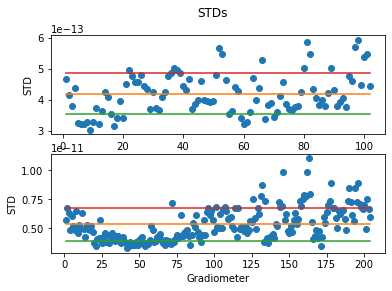

In [13]:
#Try: USING RESAMPLED DATA HERE

m_big_std_with_value, g_big_std_with_value, m_small_std_with_value, g_small_std_with_value, std_mags, std_grads=RMSE_meg_all(data=filtered_d_resamp, 
    mags=mags, grads=grads, std_lvl=1, plotflag=True, sid='1')

print('Magnetometers with high std:')
m_big_std_with_value



In [14]:
def boxplot_std_hovering(std_data=std_mags, tit=None, channel_names=None, sid='1'):

    #Boxplot with hovering annotations: https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-in-matplotlib
        
    from matplotlib import pyplot as plt

    ch_only_name_mag=[m[0] for m in channel_names] #names of channels for annotating the plot
    #std_mags_df = pd.DataFrame(std_mags, index = ch_only_name_mag) #put all stds into a data frame with channels name as index

    #Boxplot with seaborn:
    fig, ax = plt.subplots()

    #import seaborn as sns
    #bp=sns.boxplot(data=std_data, orient='h') # DONT USE SEABORN, COS IT DOWSNT WANNA HOVER-ANNOTATE IT, ONLY PYPLOTLIB WORKS FINE

    bp=plt.boxplot(std_data, vert=False)
    sc = plt.scatter(std_data, np.ones(len(std_data)), color=".25") 

        #Workaround: Doest wanna annotate the swarmplot. So make swarmplot first, then take its coordinates (cis scatter needs aboth x and y) 
        # and make scatterplot with these coordinates (it can be annotated)
        #sw=sns.swarmplot(data=std_mags, color=".25", ax=ax, alpha=0) #Makes data dots. Alpha sets swarmplot dots to invisible.
        #offs=ax.collections[0].get_offsets() #get x and y coordinates
        #ycoords=[coord[0] for coord in offs]
        #xcoords=[coord[1] for coord in offs]
        #sc = plt.scatter(xcoords,ycoords, color=".25") #use swarmplot coordinates to create scatter
        #BUT IT CHANGES THE ORDER OF STDS, THATS WHY EVERYTHING S MESSED UP! Restore the order or just keep stuff as it is now

    plt.xlabel("Standard deviation")

    #Set generic annotation:
    annot = ax.annotate("", xy=(0,0), xytext=(5,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    #xytext - how far from the dot the text is, bbox - box with name inside, arrowprops - to draw arrow

    annot.set_visible(False) #hide annotations first


    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos #resets the xy values from annot above

        #text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
        #                       " ".join([ch_only_name_mag[n] for n in ind["ind"]]))
        #shows both index and name of channel

        text = "{}".format(" ".join([ch_only_name_mag[n] for n in ind["ind"]]))
        annot.set_text(text) #resets the text from annot above
        

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)  #make annotation visible when hovering
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    ax.set_title(tit)

    #Saving interactive figure:..
    import pickle
    fig_name='Stds_all_data_'+tit+'.fig.pickle'
    fig_path='./derivatives/sub-'+sid+'/megqc/figures/'+fig_name
    f_handle=open(fig_path, 'wb') # This is for Python 3 - py2 may need `file` instead of `open`, 'wb' means 'write binary' 
    pickle.dump(fig,f_handle) #save
    f_handle.close() #close the binary file
    
    #plt.close('all') #close the figures

    return(fig_path)


In [15]:
%matplotlib qt

tit='Magnetometers'
fig_path_mags=boxplot_std_hovering(std_data=std_mags, tit=tit, channel_names=mags, sid='1')




qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


In [16]:
#Reopen saved interactive figure:
import pickle

figx = pickle.load(open(fig_path_mags, 'rb'))
figx.show() # Show the figure, edit it, etc.!

#%matplotlib inline

#REOPENS AS FIGURE, NOT PICTURE, good. BUT DOESNT DO THE HOVERING, HM...

In [17]:
boxplot_std_hovering(std_data=std_grads, tit='Gradiometers', channel_names=grads)

'./derivatives/sub-1/megqc/figures/Stds_all_data_Gradiometers.fig.pickle'

In [18]:
# STD over epochs - REWRITTEN. Now use 2 separate data frames for mags and grads in calculations:

def RMSE_meg_epoch(mags=mags, grads=grads, std_lvl=1, n_events=n_events, df_epochs_mags=df_epochs_mags, df_epochs_grads=df_epochs_grads, sid='1'):

#def RMSE_meg_epoch(data=None, std_lvl=1, stim_channel='STI101',  min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1):
    #stim_channel name is users input. but we can also let mne find it itself if 'None' is set? mne seems to have such function.

    # 1) Loop over the epochs of each channel and check for every separate magn and grad and calculate std
    import pandas as pd
    eps=list(range(0,n_events)) #list of epoch numbers
   
    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]

    #Create a function which will loop over mags or grads and calculate std:
    def std_mg(mg_names, df_mg):
        dict_mg = {}

        for ep in eps: #loop over each epoch
            rows_for_ep = [row for row in df_mg.iloc if row.epoch == ep] #take all rows of 1 epoch, all channels.
            std_epoch = [] #list with stds

            for ch_name in mg_names: #loop over channel names
                data_ch_epoch = [row_mg[ch_name] for row_mg in rows_for_ep] #take the data for 1 epoch for 1 channel
                std_ch_ep = np.std(data_ch_epoch)
                std_epoch.append(std_ch_ep)

            dict_mg[ep] = std_epoch

        df_std_mg = pd.DataFrame(dict_mg, index=mg_names)

        return(df_std_mg)

    #Apply this function for mags and grads:
    df_std_mags=std_mg(df_mg=df_epochs_mags, mg_names=mags_names)
    df_std_grads=std_mg(df_mg=df_epochs_grads, mg_names=grads_names)

    # 2) Check (which epochs for which channel) are over 1STD (or 2, 3, ets STDs) for (this epoch for all channels)

    #Find what is 1 std over all channels per 1 epoch:
    std_std_mags_per_epoch=[]
    std_std_grads_per_epoch=[]
    mean_std_mags_per_epoch=[]
    mean_std_grads_per_epoch=[]

    for ep in eps: #goes over each epoch
        std_std_mags_per_epoch.append(np.std(df_std_mags.iloc[:, ep])) #std of stds of all channels of every single epoch
        std_std_grads_per_epoch.append(np.std(df_std_grads.iloc[:, ep]))

        mean_std_mags_per_epoch.append(np.mean(df_std_mags.iloc[:, ep])) #mean of stds of all channels of every single epoch
        mean_std_grads_per_epoch.append(np.mean(df_std_grads.iloc[:, ep]))


    df_ch_ep_large_std_mags=df_std_mags.copy()
    df_ch_ep_large_std_grads=df_std_grads.copy()

    df_ch_ep_small_std_mags=df_std_mags.copy()
    df_ch_ep_small_std_grads=df_std_grads.copy()

    #Now see which channles in epoch are over 1 std or under -1 std:
    for ep in eps: #goes over each epoch   
        df_ch_ep_large_std_mags.iloc[:,ep] = df_ch_ep_large_std_mags.iloc[:,ep] > mean_std_mags_per_epoch[ep]+std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_large_std_grads.iloc[:,ep] = df_ch_ep_large_std_grads.iloc[:,ep] > mean_std_grads_per_epoch[ep]+std_lvl*std_std_grads_per_epoch[ep] #gradiometers

        df_ch_ep_small_std_mags.iloc[:,ep] = df_ch_ep_small_std_mags.iloc[:,ep] < mean_std_mags_per_epoch[ep]-std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_small_std_grads.iloc[:,ep] = df_ch_ep_small_std_grads.iloc[:,ep] < mean_std_grads_per_epoch[ep]-std_lvl*std_std_grads_per_epoch[ep] #gradiometers


    # Create csv files  for the user:

    df_std_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/std_mags_per_epoch.csv')
    
    df_std_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/std_grads_per_epoch.csv')

    df_ch_ep_large_std_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Large_std_mags_per_epoch.csv')

    df_ch_ep_large_std_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Large_std_grads_per_epoch.csv')

    df_ch_ep_small_std_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Small_std_mags_per_epoch.csv')

    df_ch_ep_small_std_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/Small_std_grads_per_epoch.csv')

In [19]:
#try (will output csv files):
# USING NON RESAMPLED DATA

RMSE_meg_epoch(mags=mags, grads=grads, std_lvl=1, sid='1') #stim_channel='STI101', std_lvl=1, min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1)

In [26]:
#Plotting function for freq. spectrum:

def Plot_periodogram(m_or_g, freqs_mat, psds, sid):

    from matplotlib import pyplot as plt

    fig=plt.figure()
    plt.plot(freqs_mat.T, np.sqrt(psds.T))
    plt.yscale='log'
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (T / Hz)')  #check the units!
    plt.title("Welch's periodogram for all "+m_or_g)
    plt.savefig('./derivatives/sub-'+sid+'/megqc/figures/PSD_over_all_data_'+m_or_g+'.png')
    #plt.show()

    #Save interactive figure:
    import pickle
    fig_name='PSD_over_all_data_interactive'+m_or_g+'.fig.pickle'
    fig_path='./derivatives/sub-'+sid+'/megqc/figures/'+fig_name
    f_handle=open(fig_path, 'wb') # This is for Python 3 - py2 may need `file` instead of `open`
    pickle.dump(fig,f_handle) 
    f_handle.close()

    return fig_path


In [27]:
#Calculate frequency spectrum:
#UPD: as discussed with Jochem, only calculate over whole time, no over concatenated epochs. For concatenated version see Funks_old notebook.

def Freq_Spectrum_meg(data=None, plotflag=True, sid='1', freq_min=1, freq_max=200, n_fft=1000, n_per_seg=1000, freq_tmin=None, freq_tmax=None):

    picks_grad = mne.pick_types(data.info, meg='grad', eeg=False, eog=False, stim=False)
    picks_magn = mne.pick_types(data.info, meg='mag', eeg=False, eog=False, stim=False)

    psds_mags, freqs_mags = psd_welch(data, fmin=freq_min, fmax=freq_max, n_jobs=-1, picks=picks_magn, n_fft=n_fft, n_per_seg=n_per_seg, tmin=freq_tmin, tmax=freq_tmax)
    psds_grads, freqs_grads = psd_welch(data, fmin=freq_min, fmax=freq_max, n_jobs=-1, picks=picks_grad, n_fft=n_fft, n_per_seg=n_per_seg, tmin=freq_tmin, tmax=freq_tmax)
    #CALCULATES NOW OVER ALL TIME. SET TIME HERE IF WANT IT FASTER OR PARTICULAR PERIOD. RESULT CAN LOOK VERY DIFFERNT.

    # n_per_seg - Length of each Welch segment (windowed with a Hamming window). Defaults to None, which sets n_per_seg equal to n_fft.
    # n_fft - The length of FFT used, must be >= n_per_seg (default: 256). The segments will be zero-padded if n_fft > n_per_seg. If n_per_seg 
    # is None, n_fft must be <= number of time points in the data.
    # These influence the bandwidth.

    #Plot the result over all time:

    freqs_mat_mags=np.tile(freqs_mags, [np.shape(psds_mags)[0],1])
    freqs_mat_grads=np.tile(freqs_grads, [np.shape(psds_grads)[0],1])

    if plotflag==True:
        
        fig_path_m=Plot_periodogram('mag', freqs_mat_mags, psds_mags, sid) #Magnetometers:
        fig_path_g=Plot_periodogram('grad', freqs_mat_grads, psds_grads, sid) #Gradiometers:

        #Freq spectrum peaks we see (visible on shorter interval, ALMOST NONE SEEN when Welch is done over all time):
        #50, 100, 150 - powerline EU
        #6 noise of shielding chambers 
        #44 meg noise
        #17 - was it the train station near by?
        #10 Secret :)
        #1hz - highpass filter.
        #flat spectrum is white noise process. Has same energy in every frequency (starts around 50Hz or even below)

        #Need to find frequencies.. and filter out? 
        #Powerline
        #Eye moves 
        #Blinks
        #Cardio: try to autocreate it. Maybe it s small enough to not care?
        #Muscle movements 

    return(freqs_mags, freqs_grads, psds_mags, psds_grads, fig_path_m, fig_path_g) 

In [28]:
#try: OVER RESAMPLED WHOLE DATA

#%matplotlib inline
%matplotlib qt

freqs_mags, freqs_grads, psds_mags, psds_grads, fig_path_m, fig_path_g = Freq_Spectrum_meg(data=filtered_d_resamp, plotflag=True, sid='1', freq_min=0.5, freq_max=100, 
    n_fft=1000, n_per_seg=1000, freq_tmin=None, freq_tmax=None)



Effective window size : 2.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.6s remaining:    0.4s


Effective window size : 2.000 (s)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished


In [29]:
#Reopen saved interactive figure:
import pickle

%matplotlib qt

fig_psd_m = pickle.load(open(fig_path_m, 'rb'))
fig_psd_m.show() # Show the figure, edit it, etc.!


In [49]:
#Calculate power of chosen band for mags or grads:

def Power_of_band(freqs, f_low, f_high, psds):

    # adopted from: https://raphaelvallat.com/bandpower.html
    
    from scipy.integrate import simps

    power_per_band_list=[]
    rel_power_per_band_list=[]
    power_by_Nfreq_per_band_list=[]
    std_of_band_list=[]

    idx_band = np.logical_and(freqs >= f_low, freqs <= f_high) # Find closest indices of band in frequency vector
    #so idx_band is a list of indices frequencies that correspond to this band. F.e. for delta band these would be 
    # the indices of 0.5 ... 4 Hz)

    for ch in enumerate(psds): 
    #loop over mags channels. psd_ch_m is psd of partigular channel

        psd_ch=np.array(ch[1])

        # Compute Area under the curve (power):
        # Frequency resolution
        freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

        # Compute the absolute power by approximating the area under the curve
        band_power = simps(psd_ch[idx_band], dx=freq_res)

        #calculate the relative power: % of this band in the total bands power for this channel:
        #total_power = simps(psd_ch, dx=freq_res)
        #band_rel_power = band_power / total_power
        band_rel_power=band_power/simps(psd_ch, dx=freq_res)

        #devide the power by the  number of frequencies in the band, to compare with RMSE later:
        power_compare=band_power/sum(idx_band) 

        #RMSE of the frequency band for particukar band, particylar channel (should be same as vakue above):
        #US THIS RE CORRECT APPROACH OR DO WE CALCULATE SMTH DIFFERENT?
        std_band=np.std(psd_ch[idx_band])

        power_per_band_list.append(band_power)
        rel_power_per_band_list.append(band_rel_power)
        power_by_Nfreq_per_band_list.append(power_compare)
        std_of_band_list.append(std_band)

    return(power_per_band_list, power_by_Nfreq_per_band_list, rel_power_per_band_list, std_of_band_list)


In [50]:
def Power_of_freq_meg(mags, grads, freqs_mags, freqs_grads, psds_mags, psds_grads, mean_power_per_band_needed, plotflag, sid):

    # Power of frequencies calculation for all mags + grads channels separately, 
    # saving power + power/freq value in data frames.

    import pandas as pd
    
    # Calculate the band power:
    wave_bands=[[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
    #delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), and gamma (30–100 Hz) bands

    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]

    dict_mags_power = {}
    dict_grads_power = {}

    dict_mags_power_freq = {}
    dict_grads_power_freq = {}

    dict_mags_rel_power = {}
    dict_grads_rel_power = {}

    dict_mags_std_of_band = {}
    dict_grads_std_of_band = {}

    for w in enumerate(wave_bands): #loop over bands

        f_low, f_high = w[1] # Define band lower and upper limits

    #loop over mags, then grads

        power_per_band_list_m, power_by_Nfreq_per_band_list_m, rel_power_per_band_list_m, std_of_band_list_m=Power_of_band(freqs_mags, f_low, f_high, psds_mags)
        power_per_band_list_g, power_by_Nfreq_per_band_list_g, rel_power_per_band_list_g, std_of_band_list_g=Power_of_band(freqs_grads, f_low, f_high, psds_grads)
        
        dict_mags_power[w[0]] = power_per_band_list_m
        dict_grads_power[w[0]] = power_per_band_list_g

        dict_mags_power_freq[w[0]] = power_by_Nfreq_per_band_list_m
        dict_grads_power_freq[w[0]] = power_by_Nfreq_per_band_list_g

        dict_mags_rel_power[w[0]] = rel_power_per_band_list_m
        dict_grads_rel_power[w[0]] = rel_power_per_band_list_g

        dict_mags_std_of_band[w[0]] = std_of_band_list_m
        dict_grads_std_of_band[w[0]] = std_of_band_list_g


    # Save all to data frames:
    df_power_mags = pd.DataFrame(dict_mags_power, index=mags_names)
    df_power_grads = pd.DataFrame(dict_grads_power, index=grads_names)

    df_power_freq_mags = pd.DataFrame(dict_mags_power_freq, index=mags_names)
    df_power_freq_grads = pd.DataFrame(dict_grads_power_freq, index=grads_names)

    df_rel_power_mags = pd.DataFrame(dict_mags_rel_power, index=mags_names)
    df_rel_power_grads = pd.DataFrame(dict_grads_rel_power, index=grads_names)

    df_std_of_band_mags = pd.DataFrame(dict_mags_std_of_band, index=mags_names)
    df_std_of_band_grads = pd.DataFrame(dict_grads_std_of_band, index=grads_names)


    # Rename columns and extract to csv:

    renamed_df_power_mags = df_power_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
    renamed_df_power_grads = df_power_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

    renamed_df_power_freq_mags = df_power_freq_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
    renamed_df_power_freq_grads = df_power_freq_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

    renamed_df_rel_power_mags = df_rel_power_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
    renamed_df_rel_power_grads = df_rel_power_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

    renamed_std_of_band_mags = df_std_of_band_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
    renamed_std_of_band_grads = df_std_of_band_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})


    # Create csv file  for the user:
    renamed_df_power_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/abs_power_mags.csv')
    renamed_df_power_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/abs_power_grads.csv')
    renamed_df_power_freq_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/power_by_Nfreq_mags.csv')
    renamed_df_power_freq_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/power_by_Nfreq_grads.csv')
    renamed_df_rel_power_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/relative_power_mags.csv')
    renamed_df_rel_power_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/relative_power_grads.csv')
    renamed_std_of_band_mags.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/std_of_band_mags.csv')
    renamed_std_of_band_grads.to_csv('./derivatives/sub-'+sid+'/megqc/csv files/std_of_band_grads.csv')

    if mean_power_per_band_needed==True: #if user wants to see average power per band over all channels - calculate and plot here:

        #Calculate power per band over all mags and all grads

        import statistics 

        power_dfs=[df_power_mags, df_rel_power_mags, df_power_grads, df_rel_power_grads, df_power_freq_mags, df_power_freq_grads]
        #keep them in this order!  

        bands_names=['delta', 'theta', 'alpha', 'beta', 'gamma']
        band_title=['Magnetometers. Average absolute power per band:', 'Magnetometers. Average relative power per band:',
        'Gradiometers. Average absolute power per band:', 'Gradiometers. Average relative power per band:', 
        'Magnetometers. Average power/freq per band:', 'Gradiometers. Average power/freq per band:']

        mean_abs_m=[]
        mean_abs_g=[]
        mean_relative_m=[]
        mean_relative_g=[]
        mean_power_nfreq_m=[]
        mean_power_nfreq_g=[]

        for d in enumerate(power_dfs):
            print(band_title[d[0]])

            for w in enumerate(bands_names): #loop over bands
                mean_power_per_band = statistics.mean(d[1].loc[:,w[0]])
                
                if d[0]==0: #df_power_mags:
                    mean_abs_m.append(mean_power_per_band) 
                elif d[0]==1: #df_rel_power_mags:
                    mean_relative_m.append(mean_power_per_band) 
                elif d[0]==2: #df_power_grads:
                    mean_abs_g.append(mean_power_per_band)
                elif d[0]==3: #df_rel_power_grads:
                    mean_relative_g.append(mean_power_per_band) 
                elif d[0]==4: #df_power_freq_mags:
                    mean_power_nfreq_m.append(mean_power_per_band)
                elif d[0]==5: #df_power_freq_grads:
                    mean_power_nfreq_g.append(mean_power_per_band)
                print(w[1], mean_power_per_band)


        if plotflag==True: #If user sets plotting to true -> show and save Visual: band power over all mags and grads as a pie chart:

            #The mean relative percentages dont sum up into 100%, so added the 'unknown' part.

            bands_names_un_m=['delta', 'theta', 'alpha', 'beta', 'gamma']
            bands_names_un_g=['delta', 'theta', 'alpha', 'beta', 'gamma']

            mean_relative_m_un=[v * 100 for v in mean_relative_m]  #in percentage
            power_unknown_m=100-(sum(mean_relative_m))*100
            if power_unknown_m>0:
                mean_relative_m_un.append(power_unknown_m)
                bands_names_un_m=['delta', 'theta', 'alpha', 'beta', 'gamma', 'unknown']

            mean_relative_g_un=[v * 100 for v in mean_relative_g] #in percentage
            power_unknown_g=100-(sum(mean_relative_g))*100
            if power_unknown_g>0:
                mean_relative_g_un.append(power_unknown_g)
                bands_names_un_g=['delta', 'theta', 'alpha', 'beta', 'gamma', 'unknown']

            fig1, axs = plt.subplots(1,2)
            fig1.suptitle('Relative power of each band')
            axs[0].pie(mean_relative_m_un, labels=bands_names_un_m, autopct='%1.1f%%') #autopct for percentage values
            axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            axs[0].set_title('Magnetometers')
            axs[1].pie(mean_relative_g_un, labels=bands_names_un_g, autopct='%1.1f%%')
            axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            axs[1].set_title('Gradiometers')
            plt.savefig('./derivatives/sub-'+sid+'/megqc/figures/Relative_power_per_band_over_all_channels.png')
            plt.show()

    return(renamed_df_power_freq_mags, renamed_std_of_band_mags)

    #we dont need these particular returns (they r already extracted to csv. Return here just to plot them)

Magnetometers. Average absolute power per band:
delta 6.434569286715877e-26
theta 2.608824050924633e-26
alpha 1.716783383579402e-26
beta 5.703166640471932e-26
gamma 1.1935286854758124e-26
Magnetometers. Average relative power per band:
delta 0.37137966623753815
theta 0.1513686955941812
alpha 0.10215063662315998
beta 0.321277998976726
gamma 0.06767791043212261
Gradiometers. Average absolute power per band:
delta 8.19644924752349e-24
theta 3.213813114557092e-24
alpha 3.6045476494656196e-24
beta 5.7889819360100895e-24
gamma 8.530424481172285e-24
Gradiometers. Average relative power per band:
delta 0.28101461005110046
theta 0.11290237156433974
alpha 0.11530130164049675
beta 0.19488272175591329
gamma 0.29641080116517227
Magnetometers. Average power/freq per band:
delta 8.043211608394847e-27
theta 2.8986933899162588e-27
alpha 1.907537092866002e-27
beta 1.5413963893167384e-27
gamma 8.464742450183067e-29
Gradiometers. Average power/freq per band:
delta 1.0245561559404362e-24
theta 3.5709034606

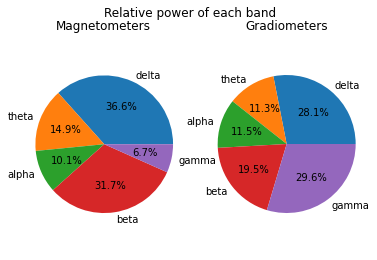

In [51]:
#try:

%matplotlib inline

renamed_df_power_freq_mags, renamed_std_of_band_mags=Power_of_freq_meg(mags=mags, grads=grads, freqs_mags=freqs_mags, freqs_grads=freqs_grads, psds_mags=psds_mags, psds_grads=psds_grads, mean_power_per_band_needed=True, plotflag=True, sid='1')
#will output dataframes

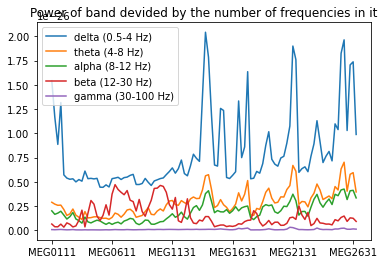

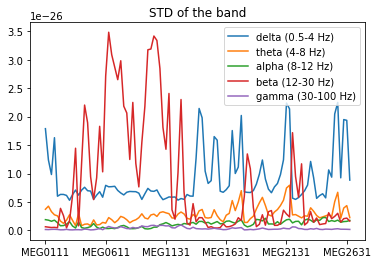

In [44]:
#So the std of band is not at all the same as total power of band devided by the number of frequencies!
# Did I get it wrong?

#Example: plot power for delta band for all magnetometers:

ax1=renamed_df_power_freq_mags.plot()
ax2=renamed_std_of_band_mags.plot()

ax1.set_title('Power of band devided by the number of frequencies in it')
ax2.set_title('STD of the band')

plt.show()
